<a href="https://colab.research.google.com/github/wenjunsun/Covid-19-analysis-with-uw-ubicomp/blob/master/2020-11/PSW_with_google_mobility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will do the same propensisty weighted methods of causal inference we have done before, but now on the Google Mobility dataset.

# 0. Go do data directory

In [1]:
cd drive/My\ Drive/covid/PSM/data

/content/drive/My Drive/covid/PSM/data


In [2]:
ls

agg_social_dist_2.csv
agg_social_dist.csv
avg_google_mobility_up_to_6_1.csv
county_data_with_reduced_covariates_with_SIP.csv
final_data_google_and_safe_graph_up_to_6_1.csv
google_mobility.csv
social_dist_aggregated_on_county.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 0.1. load R packages into Colab

In [4]:
%load_ext rpy2.ipython
# For (automatic) translation of Pandas objects to R
from rpy2.robjects import pandas2ri
pandas2ri.activate()

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [5]:
# for box and whisker plot
%%R
install.packages('lattice')
library(lattice)

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/lattice_0.20-41.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 389631 bytes (380 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[wr

In [6]:
# install package for gradient boosting machine to estimate propensity score
%%R
install.packages('twang')
library(twang)

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘minqa’, ‘numDeriv’, ‘mitools’, ‘png’, ‘jpeg’, ‘gbm’, ‘survey’, ‘xtable’, ‘latticeExtra’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/minqa_1.2.4.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 53548 bytes (52 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[w

In [7]:
%%R
install.packages('survey')
library('survey')

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/survey_4.0.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 1558121 bytes (1.5 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write 

# 1. load/preprocess data

In [8]:
data = pd.read_csv('final_data_google_and_safe_graph_up_to_6_1.csv')

In [9]:
data

,state,state_code,State Name,cnamelong,county_code,diff_in_perc_at_home,SIP?,Median Household Income,% Rural,Population_y,political_diff,% less than 18 years of age,% 65 and over,% Asian,% Black,% Hispanic,% Non-Hispanic White,census_fips_code,avg_retail_and_recreation_percent_change_6_1,avg_grocery_and_pharmacy_percent_change_6_1,avg_parks_percent_change_6_1,avg_transit_stations_percent_change_6_1,avg_workplaces_percent_change_6_1,avg_residential_percent_change_6_1
0,1.0,AL,Alabama,Autauga County,1001.0,0.050678,1,59338.0,42.0,55601,-0.494789,23.7,15.6,1.2,19.3,3.0,74.3,1001.0,-9.240741,9.111111,-34.000000,NaN,-22.481481,9.480000
1,1.0,AL,Alabama,Baldwin County,1003.0,0.050312,1,57588.0,42.3,218022,-0.577862,21.6,20.4,1.2,8.8,4.6,83.1,1003.0,-12.944444,6.120370,23.500000,-6.361111,-19.777778,6.564815
2,1.0,AL,Alabama,Barbour County,1005.0,0.007037,1,34382.0,67.8,24881,-0.056112,20.9,19.4,0.5,48.0,4.3,45.6,1005.0,2.608696,-6.203704,NaN,NaN,-15.333333,NaN
3,1.0,AL,Alabama,Bibb County,1007.0,0.011809,1,46064.0,68.4,22400,-0.555441,20.5,16.5,0.2,21.1,2.6,74.6,1007.0,0.823529,5.571429,NaN,NaN,-18.175926,NaN
4,1.0,AL,Alabama,Blount County,1009.0,0.038890,1,50412.0,90.0,57840,-0.813820,23.2,18.2,0.3,1.5,9.6,86.9,1009.0,-6.372093,6.118812,NaN,NaN,-21.111111,8.720000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2823,56.0,WY,Wyoming,Sweetwater County,56037.0,-0.018485,0,73315.0,10.9,43051,-0.535382,26.2,12.1,1.0,1.1,16.1,79.3,56037.0,-11.537037,7.305882,NaN,13.888889,-20.231481,7.120000
2824,56.0,WY,Wyoming,Teton County,56039.0,0.075183,1,99087.0,46.4,23081,0.278663,18.4,15.4,1.4,0.6,14.9,81.5,56039.0,-39.369048,-17.661017,-24.018868,-38.691358,-37.574074,NaN
2825,56.0,WY,Wyoming,Uinta County,56041.0,0.010157,0,63401.0,43.1,20299,-0.614926,28.8,14.1,0.5,0.7,9.2,87.4,56041.0,-1.125000,14.352941,NaN,12.537037,-16.435185,NaN
2826,56.0,WY,Wyoming,Washakie County,56043.0,-0.007825,0,55190.0,36.0,7885,-0.640377,22.7,21.7,0.8,0.5,14.1,82.4,56043.0,-2.767442,-12.000000,NaN,NaN,-20.960526,NaN


In [10]:
data.isnull().sum()

state                                              0
state_code                                         0
State Name                                         0
cnamelong                                          0
county_code                                        0
diff_in_perc_at_home                               0
SIP?                                               0
Median Household Income                            0
% Rural                                            0
Population_y                                       0
political_diff                                     0
% less than 18 years of age                        0
% 65 and over                                      0
% Asian                                            0
% Black                                            0
% Hispanic                                         0
% Non-Hispanic White                               0
census_fips_code                                   0
avg_retail_and_recreation_percent_change_6_1  

As we can see, there are a lot of nulls in some of the google mobility dataset. We will choose some of the good columns to analyze. Specifically, we will analyze `avg_retail_and_recreation_percent_change_6_1`, `avg_grocery_and_pharmacy_percent_change_6_1`, `avg_workplaces_percent_change_6_1 `, because they have relatively few nulls. Other behavioral data points have about 1000+ null data in our 2800+ data points, so I don't think it is a good idea to analyze those columns 

In [11]:
data = data.drop(['avg_parks_percent_change_6_1', 'avg_transit_stations_percent_change_6_1',
                  'avg_residential_percent_change_6_1'], axis = 1)

In [12]:
data.isnull().sum()

state                                             0
state_code                                        0
State Name                                        0
cnamelong                                         0
county_code                                       0
diff_in_perc_at_home                              0
SIP?                                              0
Median Household Income                           0
% Rural                                           0
Population_y                                      0
political_diff                                    0
% less than 18 years of age                       0
% 65 and over                                     0
% Asian                                           0
% Black                                           0
% Hispanic                                        0
% Non-Hispanic White                              0
census_fips_code                                  0
avg_retail_and_recreation_percent_change_6_1    249
avg_grocery_

Now we need to decide on what to do with these nulls. For now I will just delete rows with any nulls in these 3 columns `avg_retail_and_recreation_percent_change_6_1`, `avg_grocery_and_pharmacy_percent_change_6_1`, `avg_workplaces_percent_change_6_1`. Later we can think particularly how to deal with these nulls. Maybe we can imputate by regression or something.

In [13]:
data.dropna(subset = ['avg_retail_and_recreation_percent_change_6_1',
                      'avg_grocery_and_pharmacy_percent_change_6_1',
                      'avg_workplaces_percent_change_6_1'], inplace = True)

In [14]:
data.isnull().sum()

state                                           0
state_code                                      0
State Name                                      0
cnamelong                                       0
county_code                                     0
diff_in_perc_at_home                            0
SIP?                                            0
Median Household Income                         0
% Rural                                         0
Population_y                                    0
political_diff                                  0
% less than 18 years of age                     0
% 65 and over                                   0
% Asian                                         0
% Black                                         0
% Hispanic                                      0
% Non-Hispanic White                            0
census_fips_code                                0
avg_retail_and_recreation_percent_change_6_1    0
avg_grocery_and_pharmacy_percent_change_6_1     0


In [15]:
data.shape

(2415, 21)

Originally we had 2800 + data points, now we only have 2400! We have dropped quite a bit of data. Let's make sure we still have balanced SIP and non SIP counties within our dataset

In [16]:
data[data['SIP?'] == 0]

,state,state_code,State Name,cnamelong,county_code,diff_in_perc_at_home,SIP?,Median Household Income,% Rural,Population_y,political_diff,% less than 18 years of age,% 65 and over,% Asian,% Black,% Hispanic,% Non-Hispanic White,census_fips_code,avg_retail_and_recreation_percent_change_6_1,avg_grocery_and_pharmacy_percent_change_6_1,avg_workplaces_percent_change_6_1
94,5.0,AR,Arkansas,Arkansas County,5001.0,0.002032,0,43887.0,34.7,17769,-0.305821,22.9,19.6,0.8,24.5,3.3,69.5,5001.0,-8.648148,4.566038,-14.157895
95,5.0,AR,Arkansas,Ashley County,5003.0,0.004202,0,41127.0,51.7,20046,-0.365018,22.9,20.4,0.3,24.5,5.5,68.3,5003.0,-9.058824,3.450980,-16.283019
96,5.0,AR,Arkansas,Baxter County,5005.0,-0.000820,0,39686.0,65.8,41619,-0.536072,17.7,30.9,0.5,0.4,2.5,94.5,5005.0,-3.027778,13.000000,-15.777778
97,5.0,AR,Arkansas,Benton County,5007.0,0.075433,0,68978.0,25.2,272608,-0.348571,26.3,13.4,4.1,1.8,16.9,73.0,5007.0,-15.111111,-1.055556,-28.601852
98,5.0,AR,Arkansas,Boone County,5009.0,-0.000736,0,44482.0,62.2,37480,-0.584465,22.9,20.7,0.7,0.4,2.6,93.6,5009.0,-5.212963,6.073684,-21.611111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2822,56.0,WY,Wyoming,Sublette County,56035.0,0.042121,0,74570.0,100.0,9813,-0.643472,22.5,19.5,0.7,0.8,7.5,89.0,56035.0,-25.159091,-19.428571,-24.368421
2823,56.0,WY,Wyoming,Sweetwater County,56037.0,-0.018485,0,73315.0,10.9,43051,-0.535382,26.2,12.1,1.0,1.1,16.1,79.3,56037.0,-11.537037,7.305882,-20.231481
2825,56.0,WY,Wyoming,Uinta County,56041.0,0.010157,0,63401.0,43.1,20299,-0.614926,28.8,14.1,0.5,0.7,9.2,87.4,56041.0,-1.125000,14.352941,-16.435185
2826,56.0,WY,Wyoming,Washakie County,56043.0,-0.007825,0,55190.0,36.0,7885,-0.640377,22.7,21.7,0.8,0.5,14.1,82.4,56043.0,-2.767442,-12.000000,-20.960526


In [17]:
data[data['SIP?'] == 1]

,state,state_code,State Name,cnamelong,county_code,diff_in_perc_at_home,SIP?,Median Household Income,% Rural,Population_y,political_diff,% less than 18 years of age,% 65 and over,% Asian,% Black,% Hispanic,% Non-Hispanic White,census_fips_code,avg_retail_and_recreation_percent_change_6_1,avg_grocery_and_pharmacy_percent_change_6_1,avg_workplaces_percent_change_6_1
0,1.0,AL,Alabama,Autauga County,1001.0,0.050678,1,59338.0,42.0,55601,-0.494789,23.7,15.6,1.2,19.3,3.0,74.3,1001.0,-9.240741,9.111111,-22.481481
1,1.0,AL,Alabama,Baldwin County,1003.0,0.050312,1,57588.0,42.3,218022,-0.577862,21.6,20.4,1.2,8.8,4.6,83.1,1003.0,-12.944444,6.120370,-19.777778
2,1.0,AL,Alabama,Barbour County,1005.0,0.007037,1,34382.0,67.8,24881,-0.056112,20.9,19.4,0.5,48.0,4.3,45.6,1005.0,2.608696,-6.203704,-15.333333
3,1.0,AL,Alabama,Bibb County,1007.0,0.011809,1,46064.0,68.4,22400,-0.555441,20.5,16.5,0.2,21.1,2.6,74.6,1007.0,0.823529,5.571429,-18.175926
4,1.0,AL,Alabama,Blount County,1009.0,0.038890,1,50412.0,90.0,57840,-0.813820,23.2,18.2,0.3,1.5,9.6,86.9,1009.0,-6.372093,6.118812,-21.111111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2802,55.0,WI,Wisconsin,Waupaca County,55135.0,0.018980,1,58648.0,64.9,51128,-0.302460,20.3,20.9,0.6,0.5,3.3,94.1,55135.0,-12.425926,2.777778,-18.157407
2803,55.0,WI,Wisconsin,Waushara County,55137.0,-0.019303,1,52340.0,89.5,24263,-0.323301,18.3,24.4,0.6,2.0,6.3,89.6,55137.0,-16.862745,7.509804,-18.944444
2804,55.0,WI,Wisconsin,Winnebago County,55139.0,0.071851,1,57785.0,13.4,171020,-0.074431,20.5,16.4,3.0,2.2,4.2,88.4,55139.0,-23.888889,-8.194444,-23.657407
2805,55.0,WI,Wisconsin,Wood County,55141.0,0.007077,1,55879.0,36.7,73055,-0.192777,21.6,20.6,2.0,0.9,3.1,92.2,55141.0,-14.935185,-4.879630,-21.537037


We can see we lost a lot of non SIP counties data. we now only have 276 such counties and 2139 SIP counties. This might be a problem, but let's continue our analysis for now

# 2. propensity weighted methods on Google Mobility data

In [18]:
dataframe = data

In [19]:
%%R -i dataframe

logitModel <- glm(SIP.~Median.Household.Income + X..Rural +
                  political_diff+
                  X..Asian + X..Black + 
                  X..Non.Hispanic.White +
                  X..Hispanic + Population_y, data = dataframe, family = "binomial")

# put the propensity score predicted by logistic regression
# into a new column in the dataframe.
dataframe$weights<-predict(logitModel, type="response")

In [20]:
%%R
# convert 0, 1 to categories, as is required by the box whisker function
dataframe$factor_SIP <- factor(dataframe$SIP.)

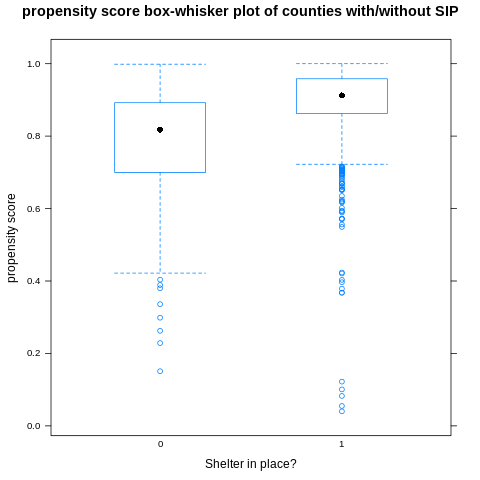

In [21]:
%%R
bwplot(weights~factor_SIP, data = dataframe, ylab = "propensity score", 
       xlab = "Shelter in place?", main = 'propensity score box-whisker plot of counties with/without SIP',
       auto.key = TRUE)

As we can see, the box whisker plot is not so great

In [22]:
%%R
dataframe$weight_ATE <- with(dataframe, ifelse(SIP.==1, 1/weights, 1/(1-weights)))

In [23]:
%%R
with(dataframe, by(weight_ATE, SIP., summary))

SIP.: 0
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.178   3.334   5.491  13.838   9.263 682.514 
------------------------------------------------------------ 
SIP.: 1
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.043   1.096   1.152   1.159  24.905 


In [24]:
# deal with extreme weights
%%R
dataframe$weight_ATE_truncated <- with(dataframe, 
                                       ifelse(weight_ATE > quantile(weight_ATE, 0.99),
                                              quantile(weight_ATE, 0.99),
                                              weight_ATE))

In [25]:
%%R
with(data = dataframe, by(weight_ATE_truncated, SIP., summary))

SIP.: 0
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.178   3.334   5.491   6.864   9.263  16.048 
------------------------------------------------------------ 
SIP.: 1
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.043   1.096   1.147   1.159  16.048 


In [26]:
%%R
covariateNames <- c('Median.Household.Income', 'X..Rural', 'political_diff',
                    'X..Asian', 'X..Black', 'X..Non.Hispanic.White', 'X..Hispanic',
                    'Population_y')

In [27]:
%%R
# sampw has to be set here or else will not get std.eff.sz which is what we want
# since we don't have sampling weight, we set it to 1
balanceTable <- bal.stat(dataframe, vars = covariateNames, treat.var = 'SIP.',
                         w.all = dataframe$weight_ATE_truncated, sampw = 1,
                         get.ks = F, estimand = 'ATE', multinom = F)

In [28]:
%%R
balance_results <- balanceTable$results

In [29]:
%%R
round(balance_results,3)

                             tx.mn      tx.sd     ct.mn      ct.sd std.eff.sz
Median.Household.Income  53774.380  14899.077 52309.452  11500.016      0.100
X..Rural                    49.330     27.916    51.363     26.369     -0.072
political_diff              -0.260      0.310    -0.307      0.237      0.154
X..Asian                     1.783      3.053     1.397      1.604      0.127
X..Black                     9.835     14.115     8.683     14.267      0.081
X..Non.Hispanic.White       73.934     20.979    78.391     15.603     -0.227
X..Hispanic                  9.968     13.980     7.840      7.843      0.153
Population_y            132297.135 372377.868 62971.833 105380.264      0.185
                          stat     p
Median.Household.Income  1.594 0.111
X..Rural                -0.957 0.339
political_diff           2.346 0.019
X..Asian                 2.737 0.006
X..Black                 0.905 0.366
X..Non.Hispanic.White   -3.141 0.002
X..Hispanic              3.255 0.001
Po

In [30]:
%%R
surveyDesignCovid <- svydesign(ids=~0, weights = ~weight_ATE_truncated,
                               data = dataframe)

In [31]:
%%R
# to obtain standard errors for propensity weighted results,
# we need to bootstrap.
surveyDesignBoot <- as.svrepdesign(surveyDesignCovid, type=c('bootstrap'), replicates=1000)

In [32]:
%%R
head(dataframe)

  state state_code State.Name      cnamelong county_code diff_in_perc_at_home
0     1         AL    Alabama Autauga County        1001          0.050678282
1     1         AL    Alabama Baldwin County        1003          0.050311979
2     1         AL    Alabama Barbour County        1005          0.007036924
3     1         AL    Alabama    Bibb County        1007          0.011808926
4     1         AL    Alabama  Blount County        1009          0.038890321
5     1         AL    Alabama Bullock County        1011         -0.009576347
  SIP. Median.Household.Income X..Rural Population_y political_diff
0    1                   59338     42.0        55601    -0.49478934
1    1                   57588     42.3       218022    -0.57786162
2    1                   34382     67.8        24881    -0.05611165
3    1                   46064     68.4        22400    -0.55544124
4    1                   50412     90.0        57840    -0.81381973
5    1                   29267     51.4       

## treatment effect size of `avg_retail_and_recreation_percent_change_6_1`

In [33]:
%%R
weightedMeans <- svyby(formula = ~avg_retail_and_recreation_percent_change_6_1, by = ~SIP., design = surveyDesignBoot,
                       FUN = svymean, covmat = TRUE)

In [34]:
%%R
weightedMeans

  SIP. avg_retail_and_recreation_percent_change_6_1        se
0    0                                    -10.39616 0.8819832
1    1                                    -13.52163 0.2490326


In [35]:
%%R
ATE_covid <- svycontrast(weightedMeans, contrasts = c(-1,1))

In [36]:
%%R
print('the effect size of having shelter in place on retail_and_recreation behavioral data')
print(ATE_covid)

[1] "the effect size of having shelter in place on retail_and_recreation behavioral data"
         contrast     SE
contrast  -3.1255 0.9286


## treatment effect size of `avg_grocery_and_pharmacy_percent_change_6_1`

In [37]:
%%R
weightedMeans <- svyby(formula = ~avg_grocery_and_pharmacy_percent_change_6_1, by = ~SIP., design = surveyDesignBoot,
                       FUN = svymean, covmat = TRUE)

In [38]:
%%R
weightedMeans

  SIP. avg_grocery_and_pharmacy_percent_change_6_1        se
0    0                                    5.433810 0.7003964
1    1                                    1.119926 0.2405937


In [39]:
%%R
ATE_covid <- svycontrast(weightedMeans, contrasts = c(-1,1))

In [40]:
%%R
print('the effect size of having shelter in place on grocery_and_pharmacy_percent_change behavioral data')
print(ATE_covid)

[1] "the effect size of having shelter in place on grocery_and_pharmacy_percent_change behavioral data"
         contrast     SE
contrast  -4.3139 0.7451


## treatment effect size of `avg_workplaces_percent_change_6_1`

In [41]:
%%R
weightedMeans <- svyby(formula = ~avg_workplaces_percent_change_6_1, by = ~SIP., design = surveyDesignBoot,
                       FUN = svymean, covmat = TRUE)

In [42]:
%%R
weightedMeans

  SIP. avg_workplaces_percent_change_6_1        se
0    0                         -20.10743 0.3320699
1    1                         -23.74943 0.1400157


In [43]:
%%R
ATE_covid <- svycontrast(weightedMeans, contrasts = c(-1,1))

In [44]:
%%R
print('the effect size of having shelter in place on workplaces_percent_change behavioral data')
print(ATE_covid)

[1] "the effect size of having shelter in place on workplaces_percent_change behavioral data"
         contrast     SE
contrast   -3.642 0.3586


# Conclusion

SIP seems to decrease people's length of stay in outside places by about `3-4%`, according to our propensity weighting methods. Which makes sense - if poeple are staying home longer, they spend less time outside. `3-4%` decrease is higher in magnitude than our `1.5%` increase in stay at home though.